#Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download the dataset

In [ ]:
import os
import urllib.request

url = "https://nrvis.com/download/data/asn/mammalia-dolphin-florida-overall.zip"
dataset_zip = "mammalia-dolphin-florida-overall.zip"
filename = "mammalia-dolphin-florida-overall.edges"
output_dir = "/content/drive/MyDrive/GraphLA/network_analysis"

os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(dataset_zip):
    print(f"Downloading {dataset_zip}...")
    try:
        urllib.request.urlretrieve(url, dataset_zip)
        print("Download completed!")
    except Exception as e:
        print(f"Error during download: {e}")

#Unzip the dataset

In [ ]:
import zipfile

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
  zip_ref.extractall('.')

#Define some utility method

In [ ]:
import pickle
import random
import sys
from os import path

import networkx as nx
import torch

def draw(G, measures, measure_name, normalize=False, log_scale=True, save=True):
    values = np.array(list(measures.values()))
    pos = nx.spring_layout(G, seed=42)

    if normalize:
        vmin, vmax = values.min(), values.max()
        if vmax != vmin:
            values = (values - vmin) / (vmax - vmin)
        else:
            values = np.zeros_like(values)
        vmin, vmax = 0, 1
    else:
        vmin, vmax = values.min(), values.max()

    fig, ax = plt.subplots(figsize=(12, 10))

    nx.draw_networkx_nodes(
        G, pos, node_size=300, node_color=values, nodelist=list(measures.keys()),
        cmap=plt.cm.plasma, ax=ax
    )

    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)

    if log_scale:
        norm = mcolors.LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label=measure_name)

    if save:
        fig.savefig(os.path.join(output_dir, f"{measure_name}_plot.png"), dpi=300, bbox_inches='tight')

    plt.title(measure_name + (" (normalized)" if normalize else ""))
    plt.axis('off')
    plt.show()


def load_graph(file_path: str) -> nx.Graph:
    if not path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    G = nx.Graph()
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            u, v = parts[0], parts[1]
            w = float(parts[2])
            G.add_edge(u, v, weight=w)

    return G


#Main

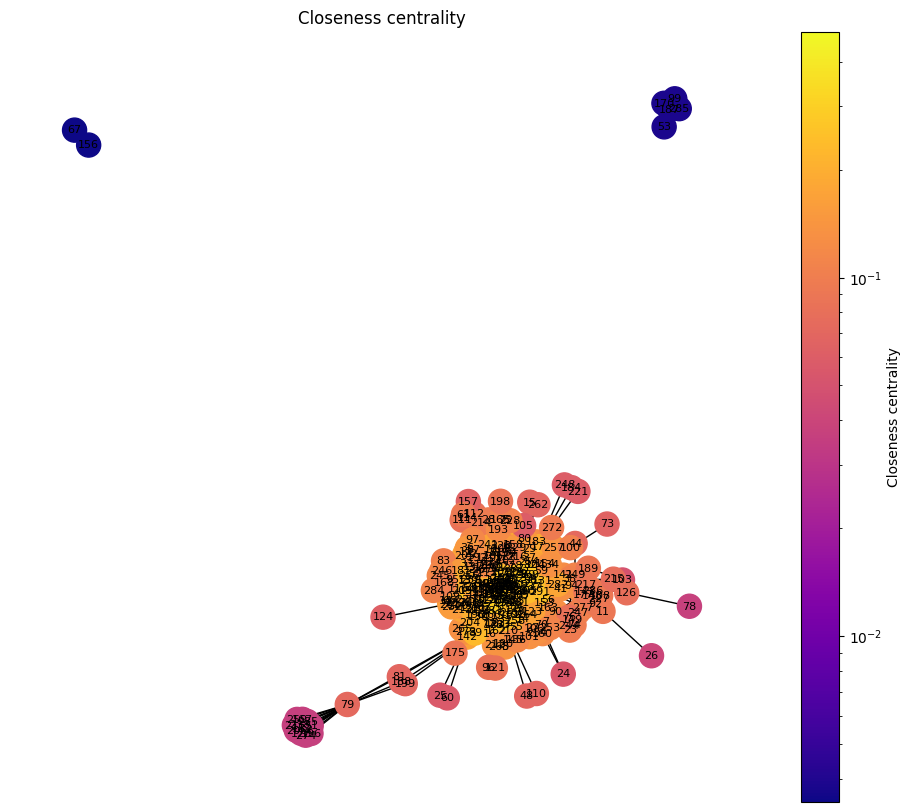

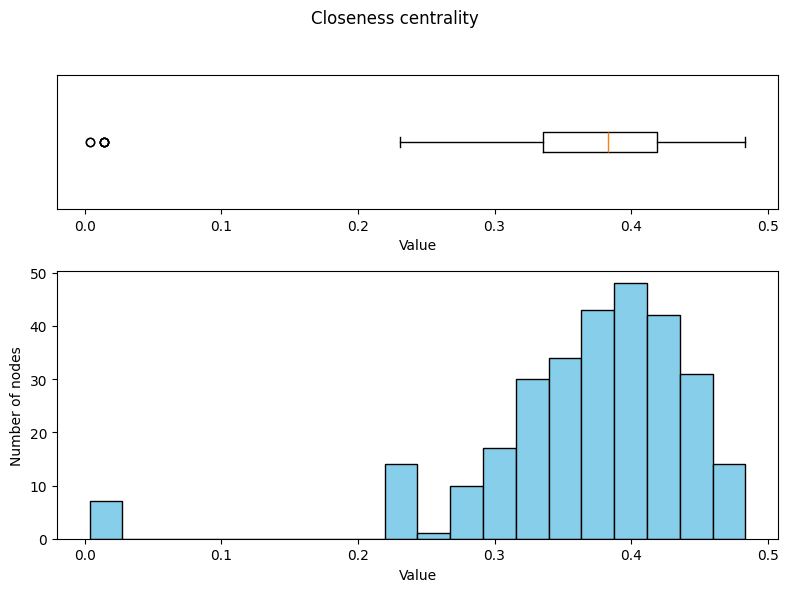

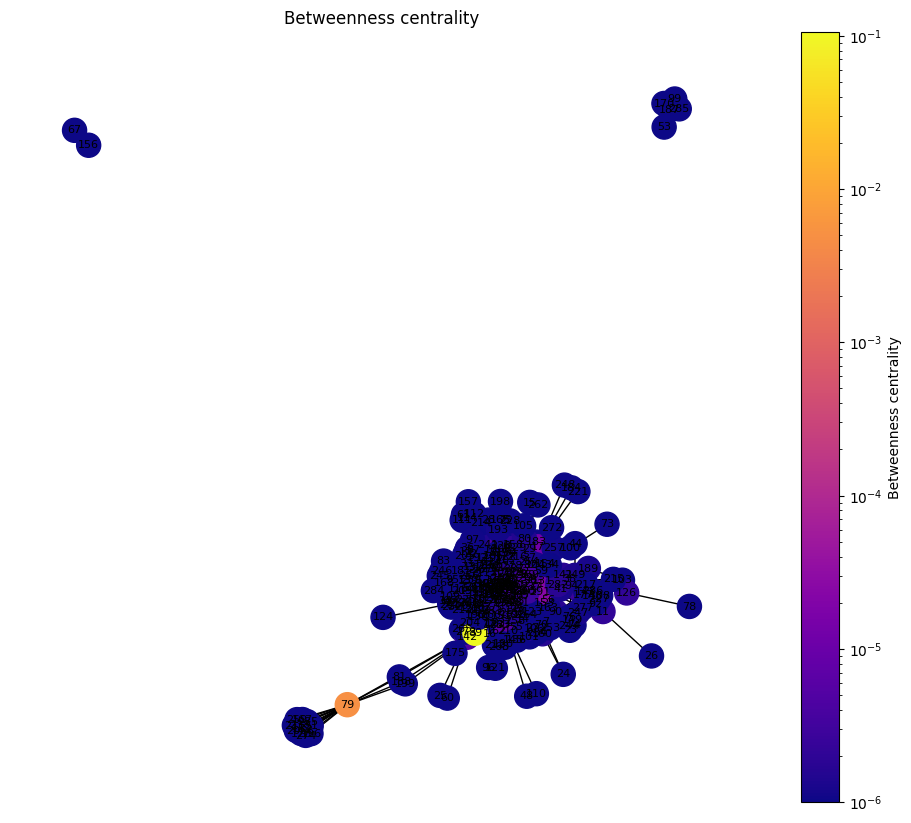

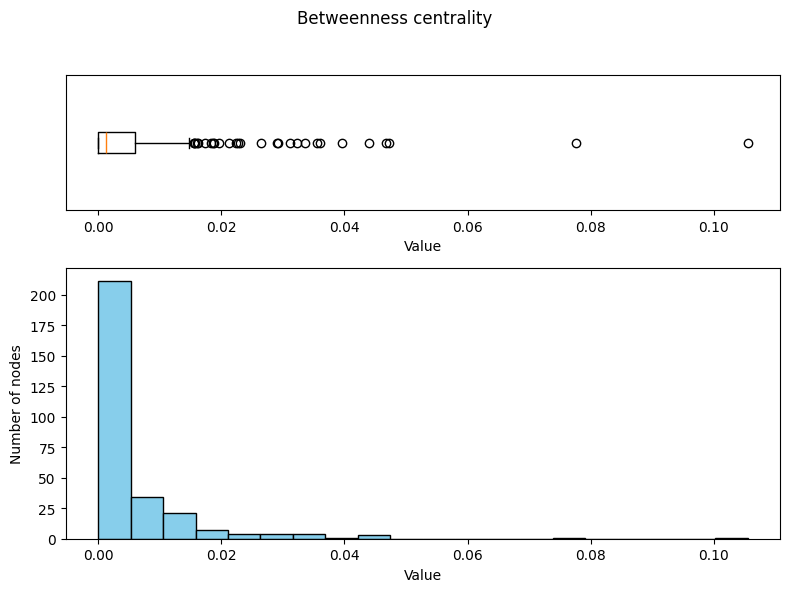

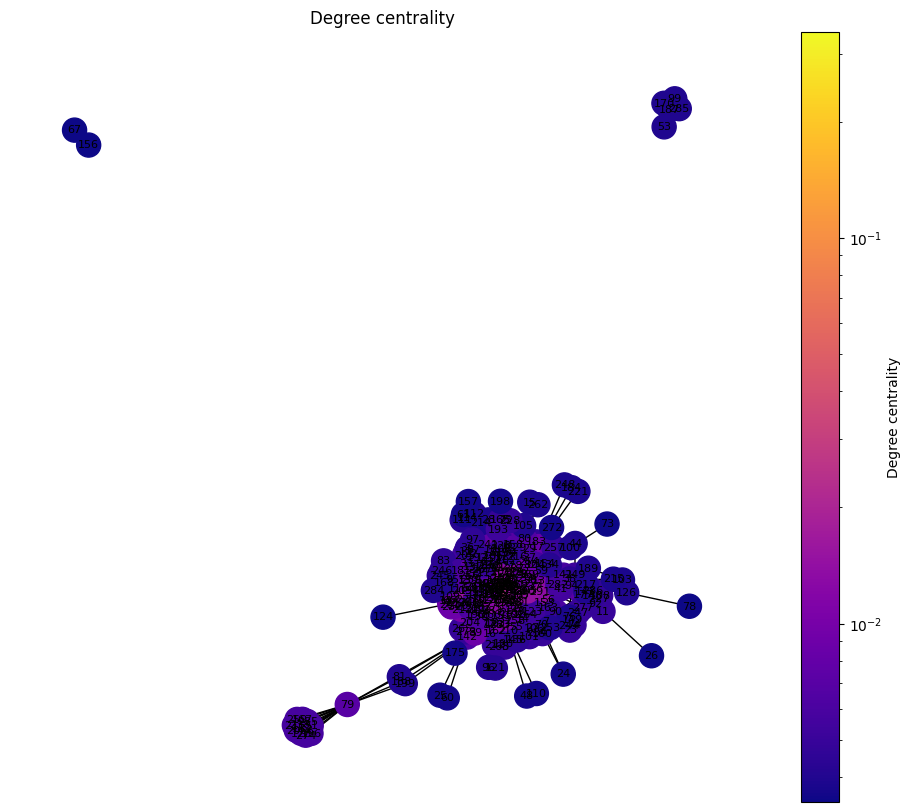

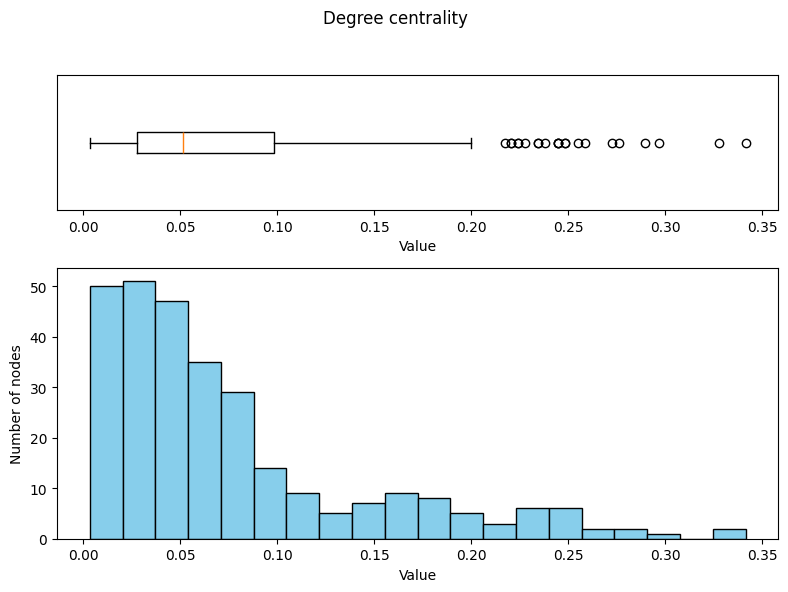

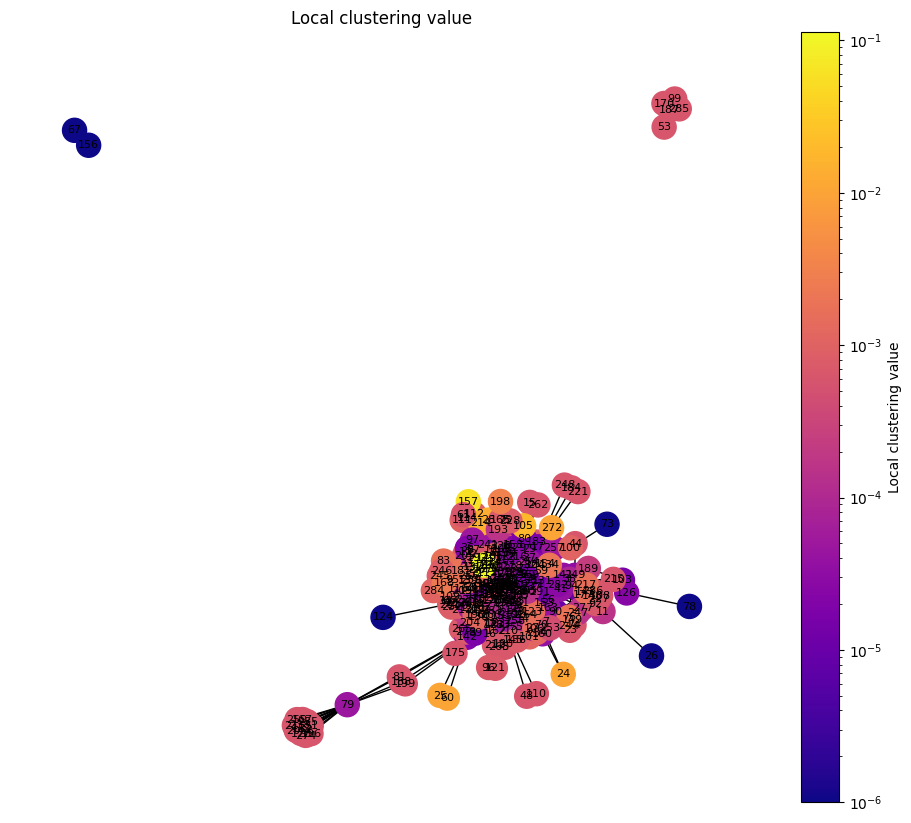

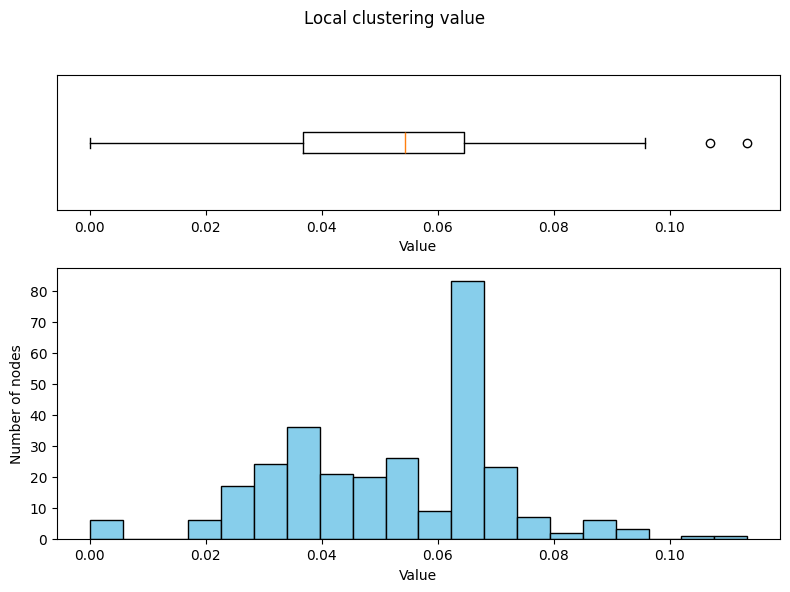

                          measure       min       max      mean       std
0            Closeness centrality  0.003448  0.483658  0.368194  0.081082
1          Betweenness centrality  0.000000  0.105470  0.005474  0.010994
2               Degree centrality  0.003448  0.341379  0.075412  0.069717
3          Local clustering value  0.000000  0.113352  0.051819  0.018780
4  Average clustering coefficient       NaN       NaN  0.051819       NaN
5   Global clustering coefficient       NaN       NaN  0.468514       NaN


In [ ]:
import os
from os import path

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import torch


# --- 1) Load graph ---
G = load_graph(filename)

# --- 2) Define measures ---
measures = {
    "Closeness centrality": nx.closeness_centrality(G, distance='weight'),
    "Betweenness centrality": nx.betweenness_centrality(G, weight='weight'),
    "Local clustering value": nx.clustering(G, weight='weight')
}

# --- 3) Compute node-level stats ---
summary_rows = []
for name, values in measures.items():
    vals = np.array(list(values.values()))

    draw(G, values, name)

    summary_rows.append({
        "measure": name,
        "min": vals.min(),
        "max": vals.max(),
        "mean": vals.mean(),
        "std": vals.std()
    })

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle(name)

    axes[0].boxplot(vals, vert=False)
    axes[0].set_xlabel("Value")
    axes[0].set_yticks([])

    axes[1].hist(vals, bins=20, color='skyblue', edgecolor='black')
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Number of nodes")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- 4) Add global graph-level measures ---
summary_rows.append({
    "measure": "Average clustering coefficient",
    "min": np.nan,
    "max": np.nan,
    "mean": nx.average_clustering(G, weight='weight'),
    "std": np.nan
})
summary_rows.append({
    "measure": "Global clustering coefficient",
    "min": np.nan,
    "max": np.nan,
    "mean": nx.transitivity(G),
    "std": np.nan
})

# --- 5) Create DataFrame ---
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(os.path.join(output_dir, "summary.csv"), index=False)

print(df_summary)